In [3]:
import pandas as pd

df = pd.read_csv('../data/raw/btc_usdt_hourly.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
#drop columns
df = df.drop(columns=['UNIT', 'TIMESTAMP', 'TYPE', 'MARKET', 'INSTRUMENT', 'MAPPED_INSTRUMENT', 
                            'BASE', 'QUOTE', 'BASE_ID', 'QUOTE_ID', 'TRANSFORM_FUNCTION', 'FIRST_TRADE_TIMESTAMP', 
                            'LAST_TRADE_TIMESTAMP', 'HIGH_TRADE_TIMESTAMP', 'LOW_TRADE_TIMESTAMP','TOTAL_TRADES_UNKNOWN', 
                            'QUOTE_VOLUME_SELL', 'VOLUME_UNKNOWN', 'QUOTE_VOLUME_BUY', 'QUOTE_VOLUME_UNKNOWN',
                            'QUOTE_VOLUME', 'FIRST_TRADE_PRICE','HIGH_TRADE_PRICE', 'LOW_TRADE_PRICE', 'LAST_TRADE_PRICE'])
print(df.columns)


Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TOTAL_TRADES', 'TOTAL_TRADES_BUY',
       'TOTAL_TRADES_SELL', 'VOLUME', 'VOLUME_BUY', 'VOLUME_SELL'],
      dtype='object')


In [6]:
import pandas as pd
import numpy as np

# ------------------------------
# 1. Compute Returns
# ------------------------------
# Percentage returns based on CLOSE prices
df['return'] = df['CLOSE'].pct_change()
# Log returns
df['log_return'] = np.log(df['CLOSE'] / df['CLOSE'].shift(1))

# ------------------------------
# 2. Compute Hourly Volatility
# ------------------------------
# Estimate volatility as the rolling standard deviation of returns (e.g., over a 12-hour window)
vol_window = 12
df['hourly_volatility'] = df['return'].rolling(window=vol_window).std()

# ------------------------------
# 3. Technical Indicators
# ------------------------------

# 3.1. 8-13-21 EMA Strategy
# Compute the 8-, 13-, and 21-period exponential moving averages.
df['EMA_8'] = df['CLOSE'].ewm(span=8, adjust=False).mean()
df['EMA_13'] = df['CLOSE'].ewm(span=13, adjust=False).mean()
df['EMA_21'] = df['CLOSE'].ewm(span=21, adjust=False).mean()
# Create a simple signal: bullish (1) when EMA_8 is above both EMA_13 and EMA_21,
# bearish (-1) when EMA_8 is below both, else neutral (0)
# Signal 1: EMA Signal
df['EMA_Signal'] = np.where((df['EMA_8'] > df['EMA_13']) & (df['EMA_8'] > df['EMA_21']), 1,
                     np.where((df['EMA_8'] < df['EMA_13']) & (df['EMA_8'] < df['EMA_21']), -1, 0))

# 3.2. Moving Average Convergence Divergence (MACD)
# Standard MACD parameters: 12-period EMA, 26-period EMA, and a 9-period Signal Line.
short_window = 12
long_window = 26
signal_window = 9
df['EMA_short'] = df['CLOSE'].ewm(span=short_window, adjust=False).mean()
df['EMA_long'] = df['CLOSE'].ewm(span=long_window, adjust=False).mean()
df['MACD'] = df['EMA_short'] - df['EMA_long']
# Signal 2: MACD Signal
df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
df['MACD_Signal'] = np.where((df['MACD'] > df['Signal_Line']) & (df['MACD'].shift(1) <= df['Signal_Line'].shift(1)), 1,
                      np.where((df['MACD'] < df['Signal_Line']) & (df['MACD'].shift(1) >= df['Signal_Line'].shift(1)), -1, 0))
# MACD Histogram (difference between MACD and its signal line)
df['MACD_Hist'] = df['MACD'] - df['Signal_Line']

# 3.3. Bollinger Bands
# Calculate a 20-period simple moving average and standard deviation.
df['SMA20'] = df['CLOSE'].rolling(window=20).mean()
df['STD20'] = df['CLOSE'].rolling(window=20).std()
df['Upper_BB'] = df['SMA20'] + (2 * df['STD20'])
df['Lower_BB'] = df['SMA20'] - (2 * df['STD20'])
# 3.4. RSI Momentum
# Compute the Relative Strength Index (RSI) using a 14-period window.
delta = df['CLOSE'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))
# Signal 3: Bollinger Bands (cum RSI) Signal
df['BB_RSI_Signal'] = np.where((df['CLOSE'] < df['Lower_BB']) & (df['RSI_14'] < 30), 1,
                        np.where((df['CLOSE'] > df['Upper_BB']) & (df['RSI_14'] > 70), -1, 0))
# Signal 4: RSI Signal
df['RSI_Signal'] = np.where((df['RSI_14'] > 30) & (df['RSI_14'].shift(1) <= 30), 1,
                     np.where((df['RSI_14'] < 70) & (df['RSI_14'].shift(1) >= 70), -1, 0))

# 3.5. Golden Cross / Death Cross
df['SMA_50'] = df['CLOSE'].rolling(window=50).mean()
df['SMA_200'] = df['CLOSE'].rolling(window=200).mean()
df['GoldenCross_Signal'] = np.where((df['SMA_50'] > df['SMA_200']) & (df['SMA_50'].shift(1) <= df['SMA_200'].shift(1)), 1,
                             np.where((df['SMA_50'] < df['SMA_200']) & (df['SMA_50'].shift(1) >= df['SMA_200'].shift(1)), -1, 0))

# 3.6. Momentum Stochastic Oscillator
low_14 = df['CLOSE'].rolling(window=14).min()
high_14 = df['CLOSE'].rolling(window=14).max()
df['%K'] = 100 * ((df['CLOSE'] - low_14) / (high_14 - low_14))
df['%D'] = df['%K'].rolling(window=3).mean()
df['Stochastic_Signal'] = np.where((df['%K'] > df['%D']) & (df['%K'].shift(1) <= df['%D'].shift(1)) & (df['%K'] < 20), 1,
                            np.where((df['%K'] < df['%D']) & (df['%K'].shift(1) >= df['%D'].shift(1)) & (df['%K'] > 80), -1, 0))

# 3.7. On balance volume (OBV)
df['OBV'] = 0
df['OBV'] = np.where(df['CLOSE'] > df['CLOSE'].shift(1), df['VOLUME'] + df['OBV'].shift(1).fillna(0),
              np.where(df['CLOSE'] < df['CLOSE'].shift(1), -df['VOLUME'] + df['OBV'].shift(1).fillna(0), df['OBV'].shift(1)))
# Signal: OBV crossing its own 20-period EMA
df['OBV_EMA20'] = df['OBV'].ewm(span=20, adjust=False).mean()
df['OBV_Signal'] = 0
df['OBV_Signal'] = np.where((df['OBV'] > df['OBV_EMA20']) & (df['OBV'].shift(1) <= df['OBV_EMA20'].shift(1)), 1,
                     np.where((df['OBV'] < df['OBV_EMA20']) & (df['OBV'].shift(1) >= df['OBV_EMA20'].shift(1)), -1, 0))

# 3.8. ATR (Average True Range Indicator)
# 1. Calculate True Range (TR)
df['H-L'] = df['HIGH'] - df['LOW']
df['H-PC'] = abs(df['HIGH'] - df['CLOSE'].shift(1))
df['L-PC'] = abs(df['LOW'] - df['CLOSE'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
# 2. Calculate ATR (14-period by default)
atr_window = 6
df['ATR'] = df['TR'].rolling(window=atr_window).mean()
# 3. Generate ATR-based breakout signal
# atr_multiplier = 1.5  # tweaked based on sensitivity
# df['ATR_Signal'] = 0
# df['ATR_Signal'] = np.where(df['CLOSE'] > df['CLOSE'].shift(1) + atr_multiplier * df['ATR'], 1,
#                      np.where(df['CLOSE'] < df['CLOSE'].shift(1) - atr_multiplier * df['ATR'], -1, 0))



# ------------------------------
# 4. Display a Sample of the Results
# ------------------------------
cols_to_display = ['CLOSE', 'return', 'hourly_volatility',
                   'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal',
                   'MACD', 'Signal_Line', 'MACD_Hist',
                   'SMA20', 'Upper_BB', 'Lower_BB',
                   'RSI_14']

print(df[cols_to_display].tail())


                              CLOSE    return  hourly_volatility  \
datetime                                                           
2025-04-03 01:00:00+00:00  83761.62  0.006417           0.010627   
2025-04-03 02:00:00+00:00  83768.01  0.000076           0.010251   
2025-04-03 03:00:00+00:00  83483.97 -0.003391           0.009495   
2025-04-03 04:00:00+00:00  83558.80  0.000896           0.009355   
2025-04-03 05:00:00+00:00  83343.75 -0.002574           0.009340   

                                  EMA_8        EMA_13        EMA_21  \
datetime                                                              
2025-04-03 01:00:00+00:00  84162.340510  84536.321847  84721.927318   
2025-04-03 02:00:00+00:00  84074.711507  84426.563012  84635.207562   
2025-04-03 03:00:00+00:00  83943.435617  84291.906867  84530.549602   
2025-04-03 04:00:00+00:00  83857.961035  84187.177315  84442.208729   
2025-04-03 05:00:00+00:00  83743.691916  84066.687698  84342.348844   

                         

In [7]:
df.to_csv(r"../data/processed/features_trading_strategy.csv")

In [8]:
import plotly.graph_objects as go

# Step 1: Find all *_Signal columns
signal_cols = [col for col in df.columns if col.endswith('_Signal')]

# Step 2: Create the base line chart for CLOSE
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['CLOSE'],
                         mode='lines',
                         name='Close Price'))

# Step 3: Loop through each signal and add buy markers
for col in signal_cols:
    signal_buy = df[df[col] == 1]
    fig.add_trace(go.Scatter(
        x=signal_buy.index,
        y=signal_buy['CLOSE'],
        mode='markers+text',
        marker=dict(symbol='triangle-up', color='green', size=10),
        name=f'{col} Buy',
        text=[col.replace('_Signal', '')] * len(signal_buy),
        textposition='top center',
        hoverinfo='text+x+y'
    ))

# Step 4: Layout
fig.update_layout(
    title="Buy Signals from Technical Indicators",
    xaxis_title="Time",
    yaxis_title="Close Price",
    legend_title="Legend",
    height=700,
    template='plotly_dark'
)

fig.show()


First 5 rows of the dataset:
                               OPEN      HIGH       LOW     CLOSE  \
datetime                                                            
2023-07-18 06:00:00+00:00  30052.22  30097.09  29921.54  29988.62   
2023-07-18 07:00:00+00:00  29988.62  30040.39  29926.70  29968.13   
2023-07-18 08:00:00+00:00  29968.13  30111.68  29881.00  30021.99   
2023-07-18 09:00:00+00:00  30021.99  30039.47  29950.01  29956.94   
2023-07-18 10:00:00+00:00  29956.94  30029.84  29908.00  29990.65   

                           TOTAL_TRADES  TOTAL_TRADES_BUY  TOTAL_TRADES_SELL  \
datetime                                                                       
2023-07-18 06:00:00+00:00         40673             17093              23580   
2023-07-18 07:00:00+00:00         27294             12709              14585   
2023-07-18 08:00:00+00:00         40869             19782              21087   
2023-07-18 09:00:00+00:00         21755              8981              12774   
2023-07

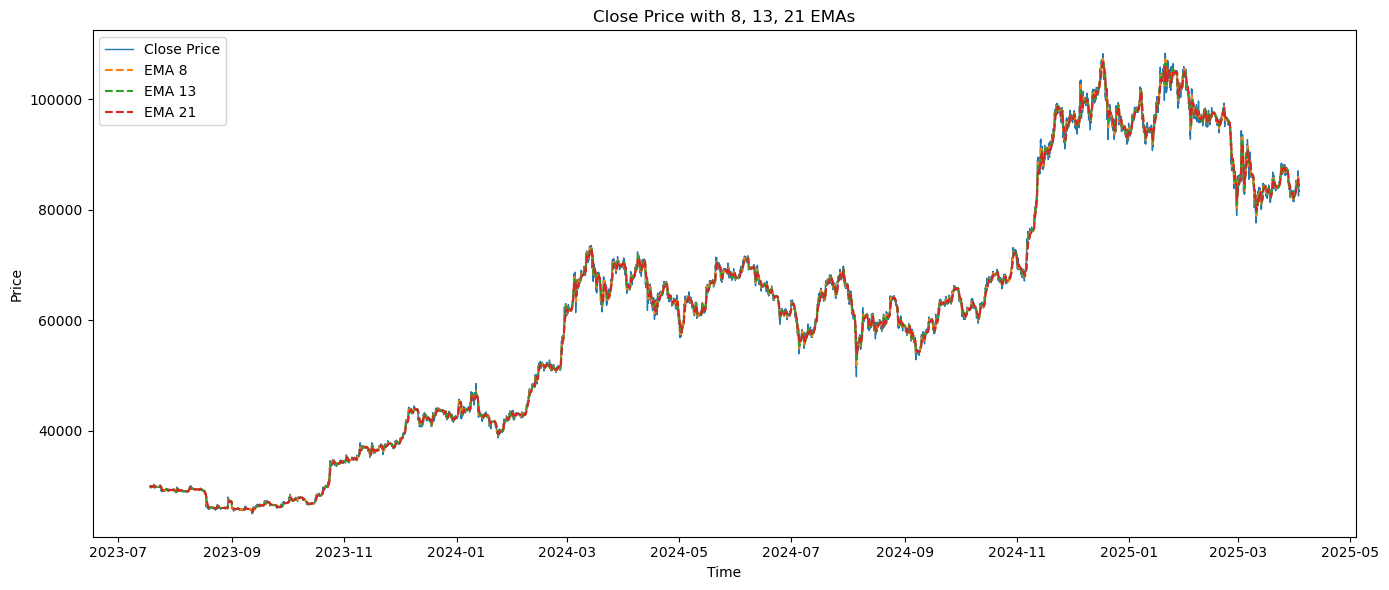

c:\Users\Justin\anaconda3\envs\dse4212\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



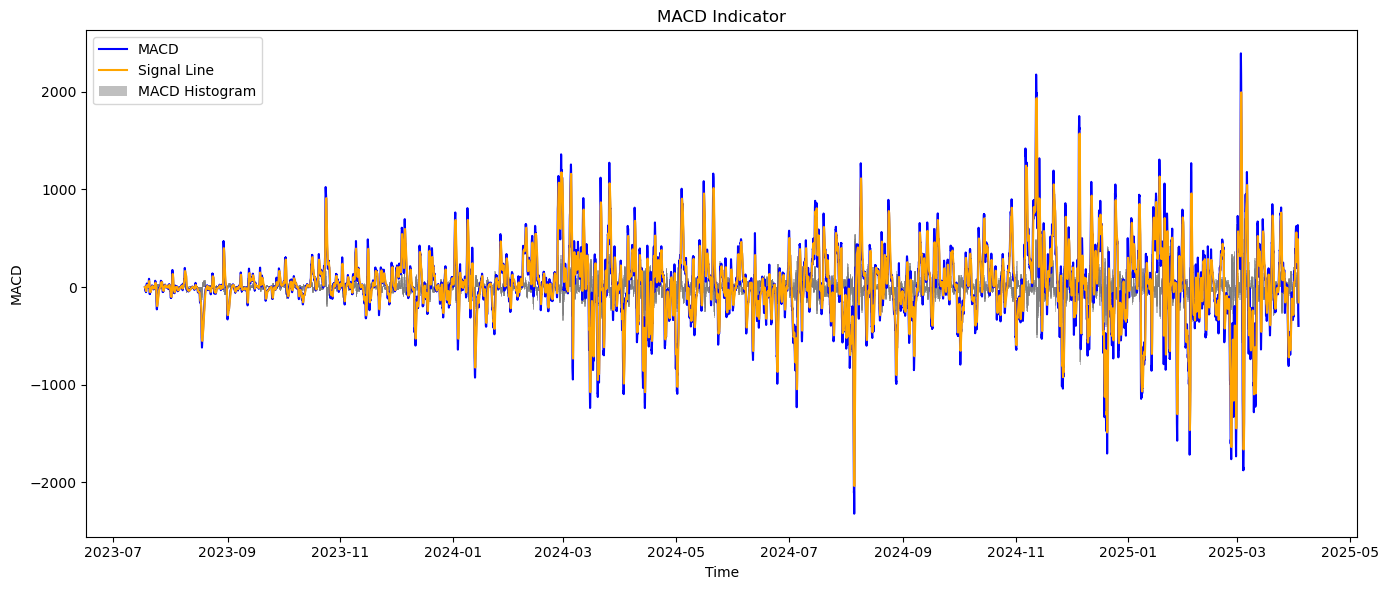

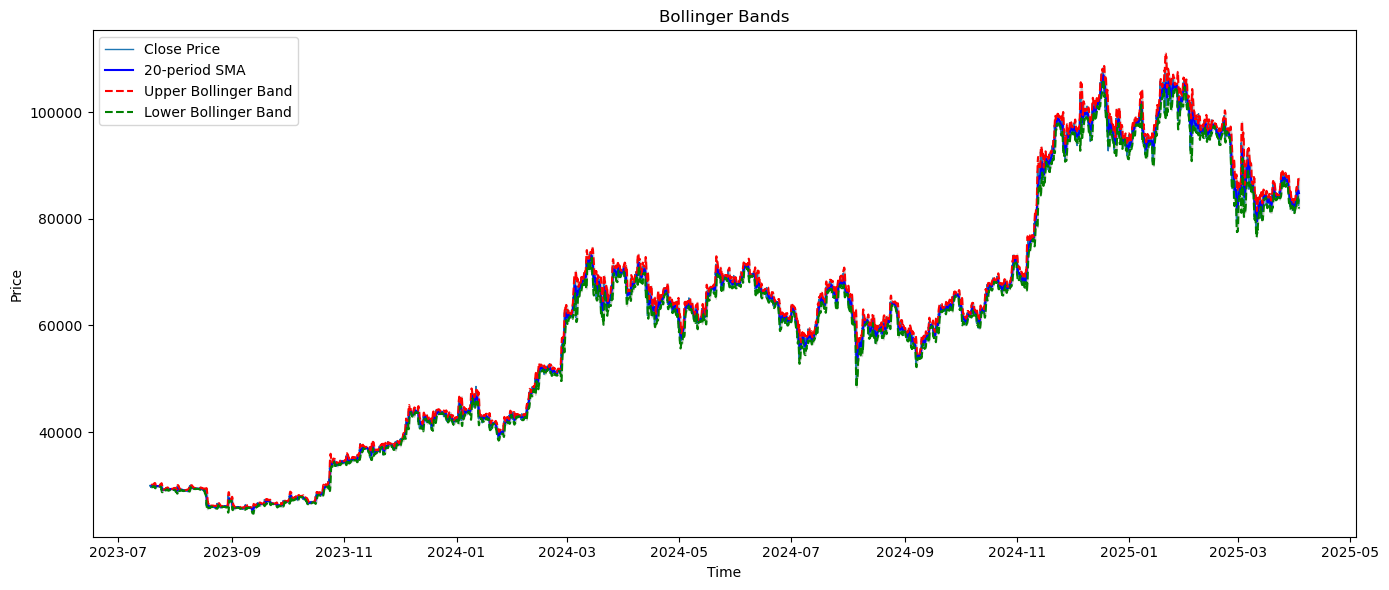

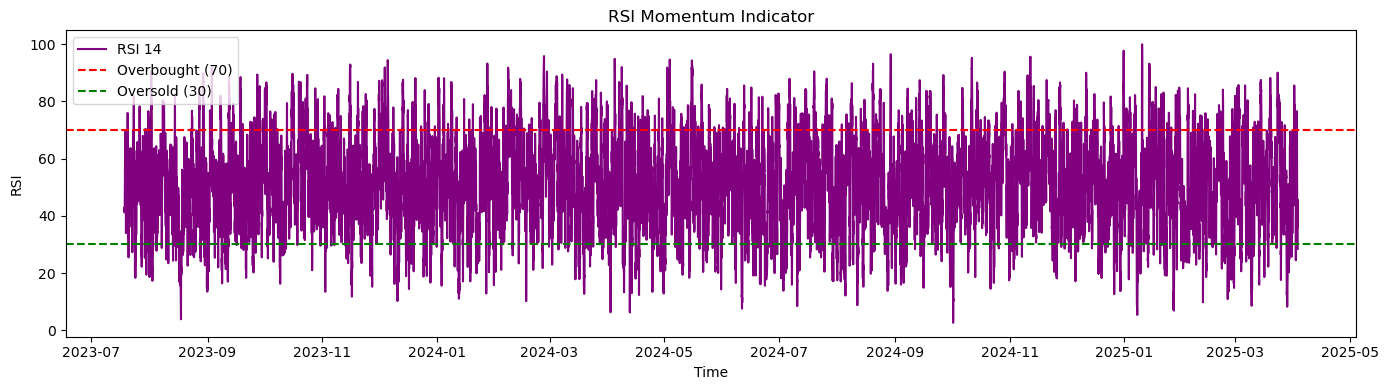

c:\Users\Justin\anaconda3\envs\dse4212\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



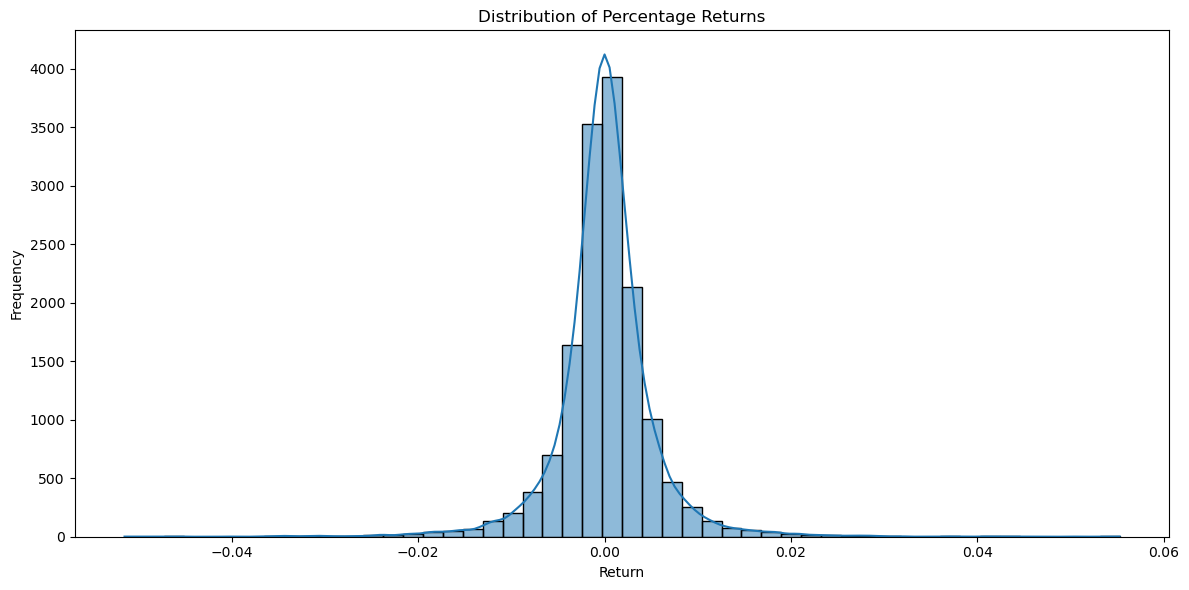

c:\Users\Justin\anaconda3\envs\dse4212\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



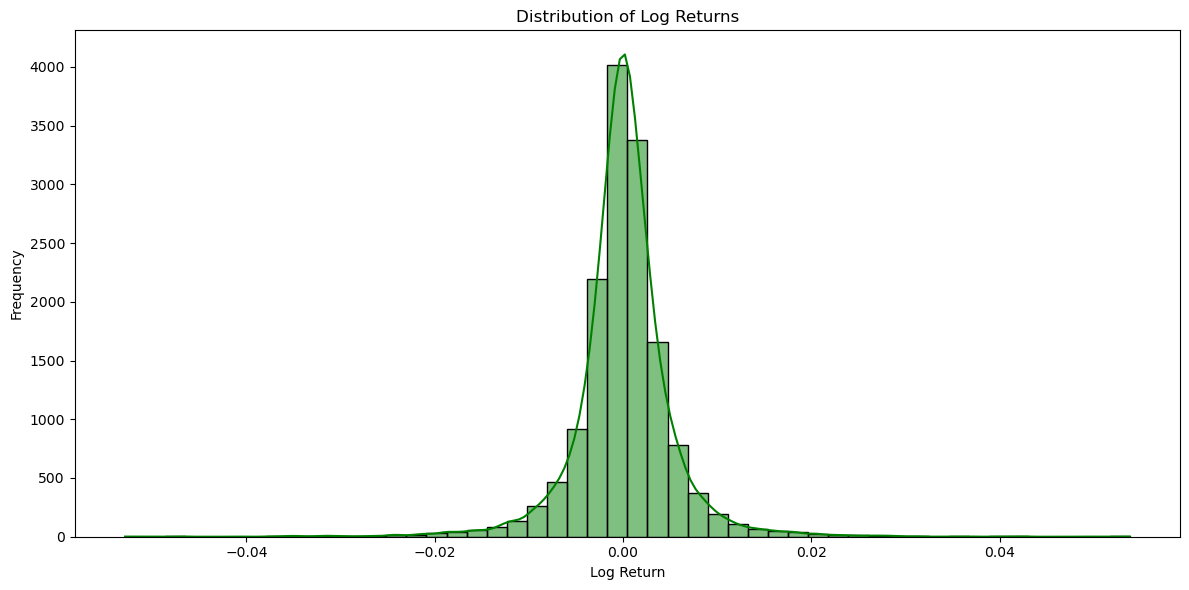

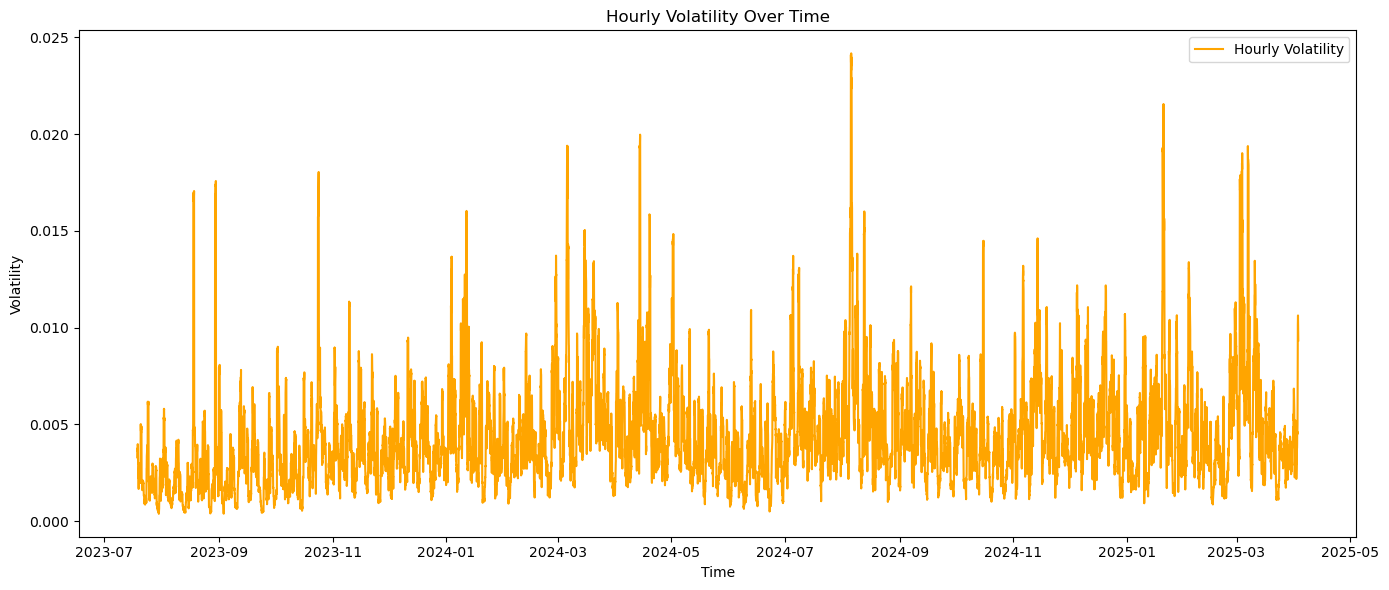

KeyError: "['EMA_signal'] not in index"

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Information & Summary
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nSummary Statistics:")
print(df.describe())

# 2. Time Series Plots: Price and EMAs
plt.figure(figsize=(14,6))
plt.plot(df.index, df['CLOSE'], label="Close Price", linewidth=1)
plt.plot(df.index, df['EMA_8'], label="EMA 8", linestyle="--")
plt.plot(df.index, df['EMA_13'], label="EMA 13", linestyle="--")
plt.plot(df.index, df['EMA_21'], label="EMA 21", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Close Price with 8, 13, 21 EMAs")
plt.legend()
plt.tight_layout()
plt.show()

# 3. MACD Visualization
plt.figure(figsize=(14,6))
plt.plot(df.index, df['MACD'], label="MACD", color="blue")
plt.plot(df.index, df['Signal_Line'], label="Signal Line", color="orange")
plt.bar(df.index, df['MACD_Hist'], label="MACD Histogram", color="gray", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("MACD")
plt.title("MACD Indicator")
plt.legend()
plt.tight_layout()
plt.show()

# 4. Bollinger Bands Plot
plt.figure(figsize=(14,6))
plt.plot(df.index, df['CLOSE'], label="Close Price", linewidth=1)
plt.plot(df.index, df['SMA20'], label="20-period SMA", color="blue")
plt.plot(df.index, df['Upper_BB'], label="Upper Bollinger Band", color="red", linestyle="--")
plt.plot(df.index, df['Lower_BB'], label="Lower Bollinger Band", color="green", linestyle="--")
plt.fill_between(df.index, df['Lower_BB'], df['Upper_BB'], color="gray", alpha=0.3)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Bollinger Bands")
plt.legend()
plt.tight_layout()
plt.show()

# 5. RSI Plot
plt.figure(figsize=(14,4))
plt.plot(df.index, df['RSI_14'], label="RSI 14", color="purple")
plt.axhline(70, linestyle="--", color="red", label="Overbought (70)")
plt.axhline(30, linestyle="--", color="green", label="Oversold (30)")
plt.xlabel("Time")
plt.ylabel("RSI")
plt.title("RSI Momentum Indicator")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Distribution of Returns and Log Returns
plt.figure(figsize=(12,6))
sns.histplot(df['return'].dropna(), bins=50, kde=True)
plt.title("Distribution of Percentage Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(df['log_return'].dropna(), bins=50, kde=True, color="green")
plt.title("Distribution of Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 7. Hourly Volatility Over Time
plt.figure(figsize=(14,6))
plt.plot(df.index, df['hourly_volatility'], label="Hourly Volatility", color="orange")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.title("Hourly Volatility Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# 8. Correlation Analysis among Features
features = ['CLOSE', 'return', 'log_return', 'hourly_volatility',
            'EMA_8', 'EMA_13', 'EMA_21', 'EMA_signal',
            'MACD', 'Signal_Line', 'MACD_Hist',
            'SMA20', 'Upper_BB', 'Lower_BB', 'RSI_14']
corr_matrix = df[features].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Engineered Features")
plt.tight_layout()
plt.show()

# 9. Additional Scatter Plot: RSI vs. Returns
plt.figure(figsize=(10,6))
sns.scatterplot(x='RSI_14', y='return', data=df, alpha=0.6)
plt.title("Scatter Plot of RSI vs. Returns")
plt.xlabel("RSI (14)")
plt.ylabel("Return")
plt.tight_layout()
plt.show()


In [10]:
df.to_csv('../data/processed/btc_usdt_hourly_processed_REAL_04_April.csv', index=True)
print("Data processing and feature engineering completed and saved")
print(df.columns)

Data processing and feature engineering completed and saved
Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TOTAL_TRADES', 'TOTAL_TRADES_BUY',
       'TOTAL_TRADES_SELL', 'VOLUME', 'VOLUME_BUY', 'VOLUME_SELL', 'return',
       'log_return', 'hourly_volatility', 'EMA_8', 'EMA_13', 'EMA_21',
       'EMA_Signal', 'EMA_short', 'EMA_long', 'MACD', 'Signal_Line',
       'MACD_Signal', 'MACD_Hist', 'SMA20', 'STD20', 'Upper_BB', 'Lower_BB',
       'RSI_14', 'BB_RSI_Signal', 'RSI_Signal', 'SMA_50', 'SMA_200',
       'GoldenCross_Signal', '%K', '%D', 'Stochastic_Signal', 'OBV',
       'OBV_EMA20', 'OBV_Signal', 'H-L', 'H-PC', 'L-PC', 'TR', 'ATR'],
      dtype='object')
